In [ ]:
import requests
import os
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.MobileNet import MobileNetV2,preprocess_input
#from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

In [ ]:
!pip install clip


  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6988 sha256=da34f3ba2235bbb97e65a8442e9e047300cc86fa17ea62f921c377ff545caaa3
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip


In [ ]:
import os
import tarfile
import shutil
from sklearn.model_selection import train_test_split
import requests
import zipfile

# Step 1: Download and Extract the Dataset
def download_and_extract(dataset_url, extract_to):
    zip_path = 'caltech101.zip'
    # Download the dataset
    print("Downloading dataset...")
    response = requests.get(dataset_url, stream=True)
    with open(zip_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

    # Extract the dataset
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Zip extraction complete.")

    # Check for tar file inside extracted folder
    tar_path = os.path.join(extract_to, "caltech-101", "101_ObjectCategories.tar.gz")
    if os.path.exists(tar_path):
        print("Extracting .tar file...")
        with tarfile.open(tar_path, 'r') as tar_ref:
            tar_ref.extractall(extract_to)
        print(".tar extraction complete.")

def split_data(source_dir, train_dir, val_dir, test_dir, val_size=0.2, test_size=0.1):
    """
    Splits the dataset into train, validation, and test sets.

    Args:
    - source_dir: Directory containing the dataset with categories as subdirectories.
    - train_dir: Directory to save training data.
    - val_dir: Directory to save validation data.
    - test_dir: Directory to save test data.
    - val_size: Proportion of the dataset to use for validation (relative to train + val).
    - test_size: Proportion of the dataset to use for testing (relative to the total data).
    """
    print("Splitting dataset into train, validation, and test sets...")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)

            # Split into train+val and test
            train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

            # Further split train+val into train and val
            train_images, val_images = train_test_split(train_val_images, test_size=val_size / (1 - test_size), random_state=42)

            # Create category subdirectories
            os.makedirs(os.path.join(train_dir, category), exist_ok=True)
            os.makedirs(os.path.join(val_dir, category), exist_ok=True)
            os.makedirs(os.path.join(test_dir, category), exist_ok=True)

            # Copy images to respective directories
            for img in train_images:
                shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))
            for img in val_images:
                shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))
            for img in test_images:
                shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category, img))

    print("Dataset split completed.")


# Step 3: Run the Complete Workflow
dataset_url = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"
base_dir = "/content"
extract_to = os.path.join(base_dir)
source_dir = os.path.join(base_dir, "101_ObjectCategories")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir=os.path.join(base_dir, "test")

# Download, Extract, and Split
download_and_extract(dataset_url, base_dir)
!rm -rf  '101_ObjectCategories/BACKGROUND_Google' #Linux

if os.path.exists(source_dir):
    split_data(source_dir, train_dir, val_dir,test_dir)
else:
    print(f"Source directory not found: {source_dir}")

print("Train directory:", train_dir)
print("Validation directory:", val_dir)

Download complete.
Extracting dataset...
Zip extraction complete.
Extracting .tar file...
.tar extraction complete.
Splitting dataset into train, validation, and test sets...
Dataset split completed.
Train directory: /content/train
Validation directory: /content/val


In [ ]:
!rm -rf  'test/BACKGROUND_Google' #Linux

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalMaxPooling2D

img_size =224

model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')



# model = load_model('/content/pretrained_cnn_model (2).h5')  # Or build_custom_model() for a new model


# img_size =128
# model = load_model('/content/autoencoder_model.h5')  # Or build_custom_model() for a new model

# # Add global pooling layer to mimic ResNet50 behavior
# x = model.output
# x = GlobalMaxPooling2D()(x)  # Use pooling='max' behavior
# custom_model = Model(inputs=model.input, outputs=x)

In [ ]:
batch_size = 128
root_dir = '101_ObjectCategories'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

feature_list = model.predict(datagen, num_epochs)
print("Num images   = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)
# Num images   =  8677
# Shape of feature_list =  (8677, 2048)

Found 8677 images belonging to 101 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 351s 5s/step
Num images   =  8677
Shape of feature_list =  (8677, 2048)


In [ ]:
# Get full path for all the images in our dataset
filenames = [root_dir + '/' + s for s in datagen.filenames]

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# ref https://datascience.stackexchange.com/questions/31167/how-to-predict-an-image-using-saved-model
img_path = '/content/test/brontosaurus/image_0037.jpg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
            plotnumber+=1
    plt.tight_layout()

(1, 5)


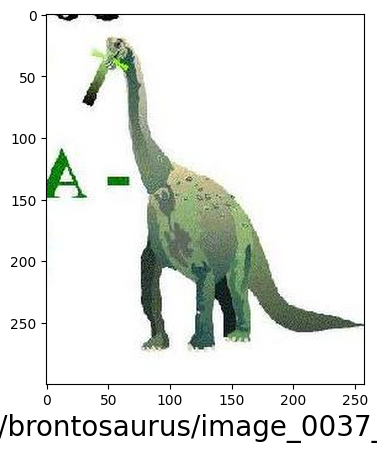

********* Predictions ***********


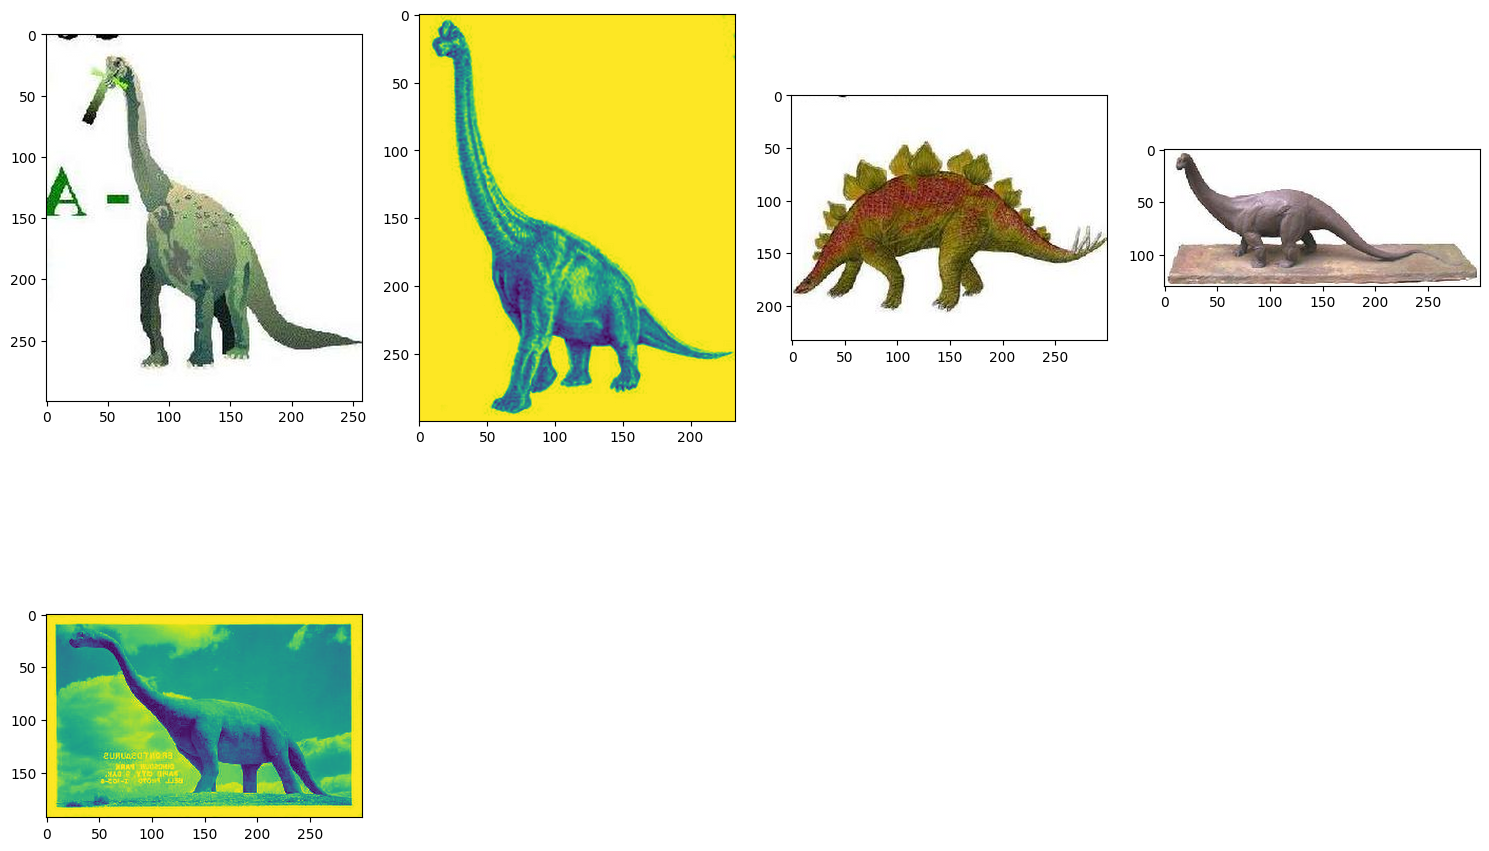

In [ ]:
print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

In [ ]:
pca = PCA(n_components=100)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [ ]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',                               metric='euclidean')
neighbors_pca_features.fit(compressed_features)

In [ ]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model, Model
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

# Load models
autoencoder = load_model("autoencoder_model_15_epochs.h5")
encoder = Model(autoencoder.input, autoencoder.layers[-7].output)
resnet = ResNet50(weights="imagenet", include_top=False, pooling="avg")  # ResNet for feature extraction

# Function to preprocess images


def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size, color_mode="grayscale")  # Ensure grayscale
    img = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img, axis=0)  # Add batch dimension


# Feature extraction
def extract_autoencoder_features(image_path):
    img = preprocess_image(image_path, target_size=(128, 128))
    features = encoder.predict(img)  # Shape: (1, ...)
    return features.flatten()  # Flatten to 1D array


def extract_resnet_features(image_path):
    input_shape = (img_size, img_size, 3)
    img = image.load_img(image_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = resnet.predict(preprocessed_img)
    return features.flatten()

# Dataset directory
dataset_dir = "./test"
image_paths = []
labels = []

# Traverse dataset folders and collect image paths and labels
for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):  # Check if it's a directory
        for img_file in os.listdir(folder_path):
            if img_file.endswith((".jpg", ".png")):
                image_paths.append(os.path.join(folder_path, img_file))
                labels.append(folder)  # Use the folder name as the label

# Extract and store features
print("Extracting features for dataset...")
ori_autoencoder_features = np.array([extract_autoencoder_features(img) for img in image_paths])
ori_resnet_features = np.array([extract_resnet_features(img) for img in image_paths])
print("Feature extraction completed.")


Extracting features for dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━

In [ ]:
print("Autoencoder features shape:", ori_autoencoder_features.shape)  # Should be (n_samples, n_features)
print("ResNet features shape:", ori_resnet_features.shape)  # Should be (n_samples, n_features)

Autoencoder features shape: (911, 2048)
ResNet features shape: (911, 2048)


In [ ]:
def precision_at_k(query_idx, features, labels, k=5):
    query_features = features[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_features, features).flatten()

    # Sort indices by similarity score (descending order)
    sorted_indices = np.argsort(similarities)[::-1][1:k+1]  # Exclude the query image itself

    # Check how many retrieved images have the same label
    query_label = labels[query_idx]
    retrieved_labels = [labels[i] for i in sorted_indices]
    relevant_count = sum(1 for lbl in retrieved_labels if lbl == query_label)

    precision = relevant_count / k
    return precision, retrieved_labels

# Example usage
query_index = 0  # Index of the query image
print("Using Autoencoder Features:")
precision, retrieved = precision_at_k(query_index, autoencoder_features, labels, k=5)
print(f"Precision@5: {precision:.2f}, Retrieved Labels: {retrieved}")

print("\nUsing ResNet Features:")
precision, retrieved = precision_at_k(query_index, resnet_features, labels, k=5)
print(f"Precision@5: {precision:.2f}, Retrieved Labels: {retrieved}")


Using Autoencoder Features:
Precision@5: 0.00, Retrieved Labels: ['accordion', 'minaret', 'ant', 'ant', 'butterfly']

Using ResNet Features:
Precision@5: 0.20, Retrieved Labels: ['binocular', 'camera', 'camera', 'revolver', 'barrel']


In [ ]:
def evaluate_model(features, labels, k=5):
    precisions = []
    for i in range(len(features)):
        precision, _ = precision_at_k(i, features, labels, k)
        precisions.append(precision)
    avg_precision = np.mean(precisions)
    return avg_precision

# Evaluate Autoencoder
print("Evaluating Autoencoder...")
autoencoder_avg_precision = evaluate_model(autoencoder_features, labels, k=5)
print(f"Autoencoder Average Precision@5: {autoencoder_avg_precision:.2f}")

# Evaluate ResNet
print("Evaluating ResNet...")
resnet_avg_precision = evaluate_model(resnet_features, labels, k=5)
print(f"ResNet Average Precision@5: {resnet_avg_precision:.2f}")


Evaluating Autoencoder...
Autoencoder Average Precision@5: 0.24
Evaluating ResNet...
ResNet Average Precision@5: 0.68


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from tqdm import tqdm  # For progress tracking

# Load models
autoencoder = load_model("autoencoder_model_15_epochs.h5")
encoder = Model(autoencoder.input, autoencoder.layers[-7].output)
resnet = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# Preprocess image function
def preprocess_image_batch(image_paths, target_size=(128, 128), grayscale=False):
    color_mode = "grayscale" if grayscale else "rgb"
    batch = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=target_size, color_mode=color_mode)
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        batch.append(img)
    return np.array(batch)

# Feature extraction in batches
def extract_autoencoder_features_batch(image_paths, batch_size=32):
    features = []
    for i in range(0, len(image_paths), batch_size):
        batch = preprocess_image_batch(image_paths[i:i + batch_size], target_size=(128, 128), grayscale=True)
        batch_features = encoder.predict(batch)
        batch_flattened = batch_features.reshape(batch_features.shape[0], -1)  # Flatten each feature map
        features.extend(batch_flattened)
    return np.array(features)
# def extract_autoencoder_features_batch(image_paths, batch_size=32):
#     features = []
#     for i in range(0, len(image_paths), batch_size):
#         batch = [preprocess_image(p, target_size=(128, 128)) for p in image_paths[i:i + batch_size]]
#         batch = np.vstack(batch)  # Stack into a single array
#         batch_features = encoder.predict(batch)  # Output: (batch_size, 16, 16, 8)
#         batch_flattened = batch_features.reshape(batch_features.shape[0], -1)  # Flatten each feature map
#         features.extend(batch_flattened)
#     return np.array(features)


def extract_resnet_features_batch(image_paths, batch_size=32):
    features = []
    for i in range(0, len(image_paths), batch_size):
        batch = preprocess_image_batch(image_paths[i:i + batch_size], target_size=(224, 224), grayscale=False)
        batch = preprocess_input(batch)
        batch_features = resnet.predict(batch)
        features.extend(batch_features)
    return np.array(features)

# Dataset directory
dataset_dir = "./test"
image_paths = []
labels = []

# Collect image paths and labels
for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            if img_file.endswith((".jpg", ".png")):
                image_paths.append(os.path.join(folder_path, img_file))
                labels.append(folder)  # Folder name as the label

# Extract features
print("Extracting features for dataset...")
autoencoder_features = extract_autoencoder_features_batch(image_paths, batch_size=32)
resnet_features = extract_resnet_features_batch(image_paths, batch_size=32)
print("Feature extraction completed.")




Extracting features for dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━

In [ ]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load VGG16 model for feature extraction
vgg16 = VGG16(weights="imagenet", include_top=False, pooling="avg")  # Global Average Pooling

def extract_vgg16_features_batch(image_paths, batch_size=32, target_size=(224, 224)):
    features_list = []

    # Process images in batches
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []

        for image_path in batch_paths:
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img)
            expanded_img_array = np.expand_dims(img_array, axis=0)
            batch_images.append(expanded_img_array)

        batch_images = np.vstack(batch_images)
        preprocessed_images = preprocess_input(batch_images)

        # Extract features for the batch
        batch_features = vgg16.predict(preprocessed_images)
        features_list.append(batch_features)

    return np.vstack(features_list)  # Stack all batch features


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load MobileNetV2 model for feature extraction
mobilenet_v2 = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

def extract_mobilenet_features_batch(image_paths, batch_size=32, target_size=(224, 224)):
    features_list = []

    # Process images in batches
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []

        for image_path in batch_paths:
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img)
            expanded_img_array = np.expand_dims(img_array, axis=0)
            batch_images.append(expanded_img_array)

        batch_images = np.vstack(batch_images)
        preprocessed_images = preprocess_input(batch_images)

        # Extract features for the batch
        batch_features = mobilenet_v2.predict(preprocessed_images)
        features_list.append(batch_features)

    return np.vstack(features_list)  # Stack all batch features


<ipython-input-59-2aae9ada1f5f>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_v2 = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
import torch
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image

# Load ViT model and feature extractor
device = "cuda" if torch.cuda.is_available() else "cpu"
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit_feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

def extract_vit_features_batch(image_paths, batch_size=32, target_size=(224, 224)):
    features_list = []

    # Process images in batches
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []

        for image_path in batch_paths:
            img = Image.open(image_path).convert("RGB").resize(target_size)
            batch_images.append(img)

        # Preprocess the batch of images
        inputs = vit_feature_extractor(images=batch_images, return_tensors="pt")
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Extract features using ViT
        with torch.no_grad():
            outputs = vit_model(**inputs)

        batch_features = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        features_list.append(batch_features)

    return np.vstack(features_list)  # Stack all batch features


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

# Load the CLIP model and processor from Hugging Face
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

def extract_clip_features_batch(image_paths, batch_size=32):
    features_list = []

    # Process images in batches
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []

        for image_path in batch_paths:
            img = Image.open(image_path).convert("RGB")
            batch_images.append(img)

        # Preprocess the batch of images
        inputs = clip_processor(images=batch_images, return_tensors="pt", padding=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Extract features using CLIP
        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)

        features_list.append(image_features.cpu().numpy())

    return np.vstack(features_list)  # Stack all batch features


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
vgg16_features = extract_vgg16_features_batch(image_paths, batch_size=32)
mobilenet_features = extract_mobilenet_features_batch(image_paths, batch_size=32)
vit_features = extract_vit_features_batch(image_paths, batch_size=32)
clip_features = extract_clip_features_batch(image_paths, batch_size=32)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [ ]:
print("Autoencoder features shape:", autoencoder_features.shape)  # Should be (n_samples, n_features)
print("ResNet features shape:", resnet_features.shape)  # Should be (n_samples, n_features)
# Print the shapes of the extracted features
print("VGG16 features shape:", vgg16_features.shape)  # Should be (n_samples, n_features)
print("MobileNet features shape:", mobilenet_features.shape)  # Should be (n_samples, n_features)
print("ViT features shape:", vit_features.shape)  # Should be (n_samples, n_features)
print("CLIP features shape:", clip_features.shape)  # Should be (n_samples, n_features)



Autoencoder features shape: (911, 2048)
ResNet features shape: (911, 2048)
VGG16 features shape: (911, 512)
MobileNet features shape: (911, 1280)
ViT features shape: (911, 768)
CLIP features shape: (911, 512)


In [ ]:
def predict_top_k_labels(features, labels, test_features, k=5):
    predictions = []
    for test_feature in test_features:
        test_feature_2d = test_feature.reshape(1, -1)  # Shape (1, n_features)
        similarities = cosine_similarity(test_feature_2d, features)  # Similarity with all features
        top_k_indices = np.argsort(similarities[0])[-k:][::-1]  # Indices of top-k most similar
        predictions.append([labels[idx] for idx in top_k_indices])  # Collect top-k labels
    return predictions


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Evaluate model using top-k predictions with binary decisions
def evaluate_model_top_k_binary(features, labels, model_name="Model", k=5):
    print(f"Evaluating {model_name} with Top-{k} Neighbors...")

    # Generate top-k predictions for the dataset
    top_k_predictions = predict_top_k_labels(features, labels, features, k=k)

    # Prepare true labels and count how many are correct in top-k predictions
    y_true = labels
    binary_predictions = []
    true_counts = []  # Stores how many true labels are in top-k for each sample

    for i, top_k in enumerate(top_k_predictions):
        true_count = sum([1 for pred in top_k if pred == y_true[i]])  # Count correct labels in top-k
        true_counts.append(true_count)  # Save count

        # Binary decision: 1 if true_count > k/2, else 0
        binary_predictions.append(1 if true_count > k // 2 else 0)

    # Compute metrics
    y_binary_true = [1] * len(y_true)  # Ground truth binary (1 for all samples, as they are correct by definition)
    accuracy = accuracy_score(y_binary_true, binary_predictions)
    precision = precision_score(y_binary_true, binary_predictions, zero_division=1)
    recall = recall_score(y_binary_true, binary_predictions, zero_division=1)
    f1 = f1_score(y_binary_true, binary_predictions, zero_division=1)
    avg_true_count = sum(true_counts) / len(true_counts)  # Average number of true labels in top-k

    print(f"{model_name} Performance with Top-{k} Neighbors (Binary Decision):")
    print(f"Accuracy (Binary): {accuracy:.4f}")
    print(f"Precision (Binary): {precision:.4f}")
    print(f"Recall (Binary): {recall:.4f}")
    print(f"F1-Score (Binary): {f1:.4f}")
    print(f"Average True Predictions in Top-{k}: {avg_true_count:.4f}")
    print("\n****\n")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "avg_true_count": avg_true_count,
    }


In [ ]:
# Evaluate models
autoencoder_results_top_k_binary = evaluate_model_top_k_binary(autoencoder_features, labels, model_name="Autoencoder", k=5)
resnet_results_top_k_binary = evaluate_model_top_k_binary(resnet_features, labels, model_name="ResNet", k=5)
vgg16_results_top_k_binary = evaluate_model_top_k_binary(vgg16_features, labels, model_name="vgg16", k=5)
mobilenet_results_top_k_binary = evaluate_model_top_k_binary(mobilenet_features, labels, model_name="MobileNet", k=5)
Vit_results_top_k_binary = evaluate_model_top_k_binary(vit_features, labels, model_name="ViT", k=5)
clip_results_top_k_binary = evaluate_model_top_k_binary(clip_features, labels, model_name="Clip", k=5)


Evaluating Autoencoder with Top-5 Neighbors...
Autoencoder Performance with Top-5 Neighbors (Binary Decision):
Accuracy (Binary): 0.2722
Precision (Binary): 1.0000
Recall (Binary): 0.2722
F1-Score (Binary): 0.4280
Average True Predictions in Top-5: 2.0285

****

Evaluating ResNet with Top-5 Neighbors...
ResNet Performance with Top-5 Neighbors (Binary Decision):
Accuracy (Binary): 0.2623
Precision (Binary): 1.0000
Recall (Binary): 0.2623
F1-Score (Binary): 0.4157
Average True Predictions in Top-5: 1.9462

****

Evaluating vgg16 with Top-5 Neighbors...
vgg16 Performance with Top-5 Neighbors (Binary Decision):
Accuracy (Binary): 0.5796
Precision (Binary): 1.0000
Recall (Binary): 0.5796
F1-Score (Binary): 0.7338
Average True Predictions in Top-5: 3.1229

****

Evaluating MobileNet with Top-5 Neighbors...
MobileNet Performance with Top-5 Neighbors (Binary Decision):
Accuracy (Binary): 0.8112
Precision (Binary): 1.0000
Recall (Binary): 0.8112
F1-Score (Binary): 0.8958
Average True Prediction